In [2]:
import matplotlib.pyplot as plt
import numpy as np
from scipy.integrate import odeint
import random
import pandas as pd
from scipy.fft import fft, fftfreq
from scipy.optimize import curve_fit

Functions & defs

In [50]:
def ode_demo(y,t,b,g,m):
    """
    Differential equation of a SIR model with equal birth and deathrate.
    
    Arguments:
    y -- 
    t -- time index (days)
    b -- beta parameter (infectiousness)
    g -- gamma parameter (recovery rate)
    m -- mu parameter (birth and deathrate)
    """
    s,i,r = y
    dsdt = m - b * s * i - m * s
    didt = b * s * i - g * i - m * i
    drdt = g * i - m * r
    
    return dsdt, didt, drdt


def SIR_Events(p):
    # Death S
    if p == 0:
        # S, I, R
        return 0,0,0
    
    # Infection
    elif p == 1:
        # S, I, R
        return -1,1,0
        
    # Death I
    elif p == 2:
        # S, I, R
        return 1,-1,0
    
    # Recovered
    elif p == 3:
        # S, I, R
        return 0,-1,1
    
    # Death R
    elif p == 4:
        # S, I, R
        return 1,0,-1
        
    # Import
    elif p == 5:
        # S, I, R
        return -1,1,0
    
        
def SIR_Demo(n, max_t, beta, gamma, mu):
    # Set starting values
    S = [round(0.99*n)]
    I = [round(0.01*n)]
    R = [0]
    t = [0]
    current_t = 0
    
    while t[-1] < max_t:
        # Set rates and calculate rate sum
        rates = [mu * S[-1], beta * S[-1] * I[-1] / n,  # rate(S)
                mu * I[-1], gamma * I[-1],  # rate(I)
                mu * R[-1]]  # rate(R)
        rates_sum = sum(rates)
        
        # Get first time step
        current_t += -1*np.log(np.random.random()) / rates_sum
        
        # Calculate all events for 100 time steps
        dS, dI, dR, de = 0, 0, 0, 0
        while current_t < max_t * 0.001:  
            # Get the event
            rand = np.random.random()
            p = 0
            for i in range(len(rates)):
                if rand * rates_sum < sum(rates[:i+1]):
                    p = i
                    break
            
            # Get changes of event
            temp_dS, temp_dI, temp_dR = SIR_Events(p)
            dS += temp_dS
            dI += temp_dI
            dR += temp_dR
            current_t += -1*np.log(np.random.random()) / rates_sum
            
            # Set rates
            rates = [mu * (S[-1] + dS), beta * (S[-1] + dS) * (I[-1] + dI) / n,  # rate(S)
                    mu * (I[-1] + dI), gamma * (I[-1] + dI),  # rate(I)
                    mu * (R[-1] + dR)]  # rate(R)
            rates_sum = sum(rates)
        
        # Add new 
        t.append(t[-1] + current_t)
        current_t = 0
        S.append(S[-1] + dS)
        I.append(I[-1] + dI)
        R.append(R[-1] + dR)

    return S, I, R

def SIR_Import(n, max_t, beta, gamma, mu, epsilon):
    S = [round(0.99*n)]
    I = [round(0.01*n)]
    R = [0]
    t = [0]
    extinctions = 0
    current_t = 0

    while t[-1] < max_t:
        # Set rates
        rates = [mu * S[-1], beta * S[-1] * I[-1] / n,  # rate(S)
                mu * I[-1], gamma * I[-1],  # rate(I)
                mu * R[-1],  # rate(R)
                epsilon * S[-1]] # Import
        rates_sum = sum(rates)
        
        current_t += -1*np.log(np.random.random()) / rates_sum
        
        # Calculate all events for 100 time steps
        dS, dI, dR, de = 0, 0, 0, 0
        while current_t < max_t * 0.001:
            # Get the event
            rand = np.random.random()
            p = 0
            for i in range(len(rates)):
                if rand * rates_sum < sum(rates[:i+1]):
                    p = i
                    break
            
            # Get changes of event
            temp_dS, temp_dI, temp_dR = SIR_Events(p)
            dS += temp_dS
            dI += temp_dI
            dR += temp_dR
            current_t += -1*np.log(np.random.random()) / rates_sum
            
            # Set rates
            rates = [mu * (S[-1] + dS), beta * (S[-1] + dS) * (I[-1] + dI) / n,  # rate(S)
                    mu * (I[-1] + dI), gamma * (I[-1] + dI),  # rate(I)
                    mu * (R[-1] + dR),
                    epsilon * (S[-1] + dS)]  # rate(R)
            rates_sum = sum(rates)
            
        # Add new 
        t.append(t[-1] + current_t)
        current_t = 0
        S.append(S[-1] + dS)
        I.append(I[-1] + dI)
        R.append(R[-1] + dR)
              
        if I[-1] == 0 and I[-2] != 0:
            extinctions += 1

    return S, I, R, extinctions

Hallmark: Variability

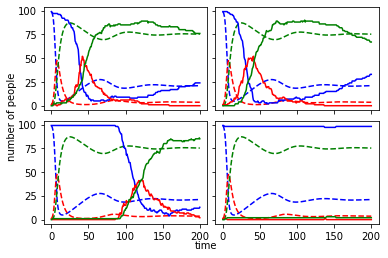

In [19]:
beta = 1.0
gamma = 0.2
mu = 0.01
population = 100
max_t = 200
epsilon = 5.5 * 10 ** -5 * np.sqrt(population) # TODO: Klopt dit wel? Kijk in boek

# Do stochastic 3 times
s1, i1, r1, e = SIR_Import(population, max_t, beta, gamma, mu, epsilon)
t1 = np.linspace(0,max_t,len(s1))
s2, i2, r2, e = SIR_Import(population, max_t, beta, gamma, mu, epsilon)
t2 = np.linspace(0,max_t,len(s2))
s3, i3, r3, e = SIR_Import(population, max_t, beta, gamma, mu, epsilon)
t3 = np.linspace(0,max_t,len(s3))
s4, i4, r4, e = SIR_Import(population, max_t, beta, gamma, mu, epsilon)
t4 = np.linspace(0,max_t,len(s4))
s = [s1, s2, s3, s4]
i = [i1, i2, i3, i4]
r = [r1, r2, r3, r4]
t = [t1, t2, t3, t4]

# Integrate ODE using odeint
time = np.linspace(0, max_t, len(s[0]))
y0 = 0.99, 0.01, 0
integrated = odeint(ode_demo, y0, time, args=(beta, gamma, mu))
s_ode, i_ode, r_ode = integrated.T

# Create subplot
f, ax = plt.subplots(2,2)
index = 0
for row in ax:
    for col in row:
        # Plot deterministic
        col.plot(time, s_ode*population, color='b', linestyle='--')
        col.plot(time, i_ode*population, color='r', linestyle='--')
        col.plot(time, r_ode*population, color='g', linestyle='--')
        # Plot stochastic
        col.plot(t[index], s[index], color='b')
        col.plot(t[index], i[index], color='r')
        col.plot(t[index], r[index], color='g')
        
        if index < 2:
            col.tick_params(axis='x', which='both', labelbottom=False)
        if index % 2 != 0:
            col.tick_params(axis='y', which='both', labelleft=False)
            
        index += 1
        
f.text(0.04, 0.5, 'number of people', va='center', rotation='vertical')
f.text(0.5, 0.04, 'time', ha='center')
plt.subplots_adjust(wspace=0.05, hspace=0.1)
# plt.savefig("figs/variability_import_epi", dpi=400)        
plt.show()

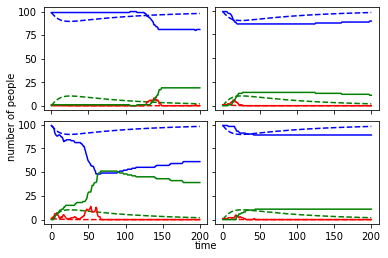

In [20]:
beta = 1.0
gamma = 1.0
mu = 0.01
population = 100
max_t = 200
epsilon = 5.5 * 10 ** -5 * np.sqrt(population) # TODO: Klopt dit wel? Kijk in boek

# Do stochastic 3 times
s1, i1, r1, e = SIR_Import(population, max_t, beta, gamma, mu, epsilon)
t1 = np.linspace(0,max_t,len(s1))
s2, i2, r2, e = SIR_Import(population, max_t, beta, gamma, mu, epsilon)
t2 = np.linspace(0,max_t,len(s2))
s3, i3, r3, e = SIR_Import(population, max_t, beta, gamma, mu, epsilon)
t3 = np.linspace(0,max_t,len(s3))
s4, i4, r4, e = SIR_Import(population, max_t, beta, gamma, mu, epsilon)
t4 = np.linspace(0,max_t,len(s4))
s = [s1, s2, s3, s4]
i = [i1, i2, i3, i4]
r = [r1, r2, r3, r4]
t = [t1, t2, t3, t4]

# Integrate ODE using odeint
time = np.linspace(0, max_t, len(s[0]))
y0 = 0.99, 0.01, 0
integrated = odeint(ode_demo, y0, time, args=(beta, gamma, mu))
s_ode, i_ode, r_ode = integrated.T

# Create subplot
f, ax = plt.subplots(2,2)
index = 0
for row in ax:
    for col in row:
        # Plot deterministic
        col.plot(time, s_ode*population, color='b', linestyle='--')
        col.plot(time, i_ode*population, color='r', linestyle='--')
        col.plot(time, r_ode*population, color='g', linestyle='--')
        # Plot stochastic
        col.plot(t[index], s[index], color='b')
        col.plot(t[index], i[index], color='r')
        col.plot(t[index], r[index], color='g')
        
        if index < 2:
            col.tick_params(axis='x', which='both', labelbottom=False)
        if index % 2 != 0:
            col.tick_params(axis='y', which='both', labelleft=False)
            
        index += 1
plt.subplots_adjust(wspace=0.05, hspace=0.1)
f.text(0.04, 0.5, 'number of people', va='center', rotation='vertical')
f.text(0.5, 0.04, 'time', ha='center')
# plt.savefig("figs/variability_import_nonepi", dpi=400)        
plt.show()

Hallmark: necative (co)-variances

In [6]:
beta = 2
gamma = 0.5
mu = 0.1
population = 1000
max_t = 60
epsilon = 5.5 * 10 ** (-5) * np.sqrt(population)
covlist= []
noiselist = []


for i in range(1000):
    S, I, R, Ext = SIR_Import(population, max_t, beta, gamma, mu, epsilon)
    T = np.linspace(0,max_t,len(S))
    
    cov = np.cov(S, I)[0, 1]
    covlist.append(cov)
    noise = np.std(S)
    noiselist.append(noise)


m, b = np.polyfit(noiselist, covlist, 1)  # fit line through data

x = np.sort(np.array(noiselist))

plt.figure()
plt.plot(noiselist, covlist, '.')
plt.plot(x, m*x+b)
#plt.xscale('symlog')
plt.yscale('symlog', linthresh=0.01)
#plt.ylim(np.min(covlist)*1.5, 0)
plt.xlabel('variance of noise [std(S)]')
plt.ylabel('covariance between S and I')
# plt.savefig("figs/covariance", dpi=400)
plt.show()

KeyboardInterrupt: 

Extinctions

[ 501.  651.  801.  951. 1101. 1251. 1401. 1551. 1701. 1851. 2001.]
[16.8, 15.4, 6.8, 7.4, 5.6, 5.6, 1.6, 1.0, 0.8, 0.2, 0.0]
[2.62098519e-218 1.88058203e-283 0.00000000e+000 0.00000000e+000
 0.00000000e+000 0.00000000e+000 0.00000000e+000 0.00000000e+000
 0.00000000e+000 0.00000000e+000 0.00000000e+000]


C:\Users\jacco\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:828: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',


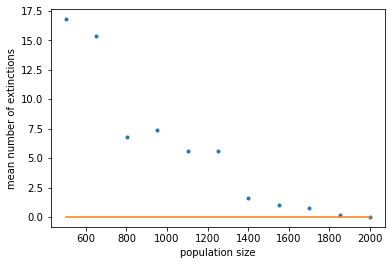

In [57]:
def fit_function(x, a, b):
    return a*np.exp(-b*x)

beta = 1.0
gamma = 0.5
mu = 0.01
population = np.linspace(501, 2001, 11)
print(population)
max_t = 365
ext_list_mean = []

for pop in population:
    ext_list = []
    for i in range(5):
        epsilon = 5.5 * 10 ** (-5) * np.sqrt(pop)
        S, I, R, Ext = SIR_Import(pop, max_t, beta, gamma, mu, epsilon)
        ext_list.append(Ext)
    ext_list_mean.append(np.mean(ext_list))

print(ext_list_mean)

popt, pcov = curve_fit(fit_function, np.array(population), np.array(ext_list_mean))

fitted = fit_function(np.array(population), *popt)
print(fitted)

plt.figure()
plt.plot(population, ext_list_mean, '.')
plt.plot(population, fitted)
plt.xlabel("population size")
plt.ylabel("mean number of extinctions")
plt.savefig("figs/extinctions", dpi=400)
plt.show()

Increased transcients, --> plotjes hardcode gaat dus ergens nog iets fout

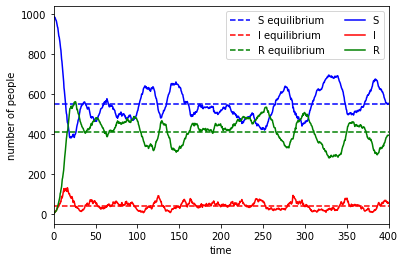

In [108]:
beta = 1
gamma = 0.5
mu = 0.05
population = 1000
max_t = 400
epsilon = 5.5 * 10 ** -5 * np.sqrt(population)

s, i, r, e = SIR_Import(population, max_t, beta, gamma, mu, epsilon)
t = np.linspace(0,max_t,len(s))


R0 = beta/(gamma+mu)
Seq = 1/R0
Ieq = (gamma/beta )* (R0-1)
Req = 1 - Seq - Ieq


plt.figure()
plt.axhline(y=Seq*population, color='b', linestyle='--', label='S equilibrium')
plt.axhline(y=Req*population, color='r', linestyle='--', label='I equilibrium')
plt.axhline(y=Ieq*population, color='g', linestyle='--', label='R equilibrium')
plt.xlim([0, max_t])
plt.plot(t, s, color='b', label='S')
plt.plot(t, i, color='r', label='I')
plt.plot(t, r, color='g', label='R')
plt.legend(ncol=2)
plt.xlabel('time')
plt.ylabel('number of people')
# plt.savefig("figs/transcients", dpi=400)
plt.show()

Stochastic Resonance

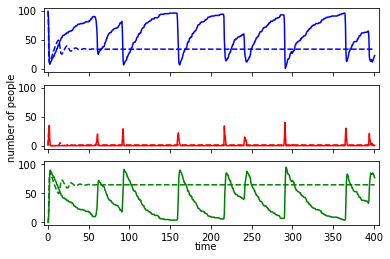

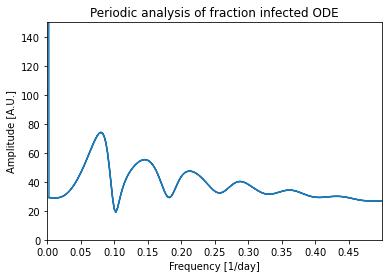

In [119]:
beta = 9
gamma = 3
mu = 3/50
population = 100
max_t = 401
epsilon = 5.5 * 10 ** -5 * np.sqrt(population)

# Integrate ODE using odeint
time = np.linspace(0, max_t, max_t*2)
y0 = 0.99, 0.01, 0
integrated = odeint(ode_demo, y0, time, args=(beta, gamma, mu))
s_ode, i_ode, r_ode = integrated.T
s_ode *= population
i_ode *= population
r_ode *= population

s, i, r, e = SIR_Import(population, max_t, beta, gamma, mu, epsilon)
t = np.linspace(0,max_t,len(s))

f, (ax1, ax2, ax3) = plt.subplots(3,1)
ax1.plot(time, s_ode, '--', color='b')
ax1.plot(t, s, color='b')
# ax1.set_xticks(np.arange(0, max_t, 25))
# ax1.grid(axis='both')
ax1.set_xlim(([-5, max_t + 5]))
ax1.tick_params(axis='x', which='both', labelbottom=False)
ax1.set_ylim([-5, 105])

ax2.plot(time, i_ode, '--', color='r')
ax2.plot(t, i, color='r')
# ax2.set_xticks(np.arange(0, max_t, 25))
# ax2.grid(axis='both')
ax2.set_xlim(([-5, max_t + 5]))
ax2.tick_params(axis='x', which='both', labelbottom=False)
ax2.set_ylim([-5, 105])

ax3.plot(time, r_ode, '--', color='g')
ax3.plot(t, r, color='g')
# ax3.set_xticks(np.arange(0, max_t, 25))
# ax3.grid(axis='both')
ax3.set_xlim(([-5, max_t + 5]))
ax3.set_ylim([-5, 105])

f.text(0.04, 0.5, 'number of people', va='center', rotation='vertical')
f.text(0.5, 0.04, 'time', ha='center')
# plt.savefig("figs/resonance", dpi=400)
plt.show()

i_ode = np.array(i_ode)
Ipower = fft(i_ode[2:])
Ipower = abs(Ipower)
xf = fftfreq(i_ode[2:].size, d=(time[1]-t[0]))
xf = abs(xf)


plt.figure()
plt.xlabel('Frequency [1/day]')
plt.ylabel('Amplitude [A.U.]')
plt.title('Periodic analysis of fraction infected ODE')
plt.plot(xf, Ipower)
plt.xlim([0.02, .5])
plt.ylim([0, 150])
plt.xticks(np.arange(0, 0.5, 0.05))
# plt.grid(axis='both')
plt.show()
